In [1]:
# %load_ext autoreload
# %autoreload 2

### Authors:
- [Karan Bhagat](mailto:kb.in.triangulum@gmail.com) - Developer
- [Christine Task](mailto:christine.task@knexusresearch.com) - Project technical lead
- [Dhruv Kapur](mailto:dhruvka@umich.edu) - Contributor

## NIST Collaborative Research Cycle (CRC)
### Example Notebook 2: Imposter plot (relationship between propensity score and inconsistencies).

The propensity metric trains a classifier to distinguish between real and synthetic data. If the data are indistinguishable the propensity distributions will peak in the 50% bin, indicating the classifier can only make a '50/50 guess' whether a given record is from the target data or deidentified data. The report.html files in the data-and-metrics-bundle contain full plots of the propensity distributions. In this notebook, we show how to collect the counts of individuals in the 100% propensity bin across all deidentified data submissions in the archive (accessing the scores in the propensity metric csv files).  The 100% bin contains people the classifier is 100% confident are synthetic--  the unreal, alien "imposter" records in the deidentified data.

One property that can make a record appear obviously synthetic is if it contains an "inconsisitency", or a violation of a deterministic constraint between features. For example, a record whose age (AGEP) is 6 years old but whose marital status (MSP) is widowed would have an age-related inconsistency. Below we provide a scatterplot comparing imposter count with inconsistency count (collected from the report json file) for each deidentified data submission.   Inconsistencies clearly explain some imposters, but not all of them. What other factors might be in play?

#### List of topics covered in this notebook:
0. [Setup notebook.](#nb2-section-0)  
1. [Load deid datasets index file (index.csv).](#nb2-section-1)  
2. [Show propensity metric plot for a deid dataset.](#nb2-section-2)
3. [Get percentage of deid samples in the 100th propensity bin.](#nb2-section-3)
4. [Get percentage of inconsistent records in each deid dataset.](#nb2-section-4)  
5. [Plot relationship between percent deid samples in 100th propensity bin and percent inconsistencies.](#nb2-section-5) 

<a id="nb2-section-0"></a>
## Setup notebook.

### Import required libraries

In [2]:
# import required libraries
from pathlib import Path  # for creating paths for the filesystem operations
import os  # for filesystem operations
import pandas as pd  # for tabular data operations
import numpy as np  # for tabular data operations
import matplotlib.pyplot as plt  # for plotting data as charts
import json

### Import local libraries present in libs package

In [3]:
# Import helper constants and functions
# libs.util has some small utility functions
# such has read_json, list_report etc.
import libs.util as u
# libs.plot module contains some helper
# funtions to create matplotlib charts
import libs.plot as plot
# libs.strs contains some constant strings
# represeting columns/feature names in index.csv file,
# report.json file, etc.
# Some examples of such constants: 
# LIBRARY_NAME, ALOGIRTHM_NAME, TARGET_DATASETetc.
from libs.strs import *
# lib.strs provides get_colors function that can be
# use to generate N random colors.
import libs.color as color

### Change Current Working Directory (CWD) to: crc_data_and_metric_bundle

In [4]:
print('CWD Before: ', Path.cwd())
# get current working directory
cwd = Path.cwd()
# get path to the directory where is notebook is located
notebook_dir = u.notebook_path()
# Name of the parent directory of this notebook is crc_data_and_metric_bundle
new_cwd = notebook_dir.parent
# Set new current working directory path which ends in crc_data_and_metric_bundle
os.chdir(new_cwd)
print('CWD After: ', Path.cwd())

CWD Before:  /Users/karan/Documents/Knexus/NIST/SDNist/crc_acceleration_bundle_1.1/crc_data_and_metric_bundle_1.1/notebooks
CWD After:  /Users/karan/Documents/Knexus/NIST/SDNist/crc_acceleration_bundle_1.1/crc_data_and_metric_bundle_1.1


<a id="nb2-section-1"></a>
## 1. Load deid datasets index file (index.csv)

index.csv file has tabular information about the deidentified (deid) datasets created using different data-deidentification libraries and algorithms. 
#### Location of index.csv: *crc_data_and_metric_bundle_2.0/index.csv*
#### Location of this notebook: *crc_data_and_metric_bundle_2.0/notebooks/intro.ipynb*

In [5]:
CWD = Path.cwd()  # get current working directory path
# Create path to the index.csv file
INDEX_FILE_PATH = Path(CWD, 'index.csv')
# read index csv into idx_df variable
# idx stands for index
idx_df = pd.read_csv(INDEX_FILE_PATH, index_col=0).reset_index(drop=True)

Index data has a total of 298 different deid. datasets and each dataset has 23 different properties.

In [6]:
# See the shape of the index dataframe.
idx_df.shape

(458, 22)

In [7]:
# See five random rows of the index dataframe
idx_df.sample(5)

,library name,algorithm name,algorithm type,target dataset,feature set name,feature space size,features list,privacy category,privacy label detail,epsilon,...,variant label detail,research papers,data path,labels path,report path,team,submission number,submission timestamp,quasi identifiers subset,deid data id
246,smartnoise-synth,pacsynth,query matching,ma2019,demographic-focused,227026800,"AGEP, SEX, MSP, RAC1P, HOUSING_TYPE, OWN_RENT,...",dp,The pac-synth synthesizer will suppress margin...,10.0,...,NaN,https://github.com/microsoft/synthetic-data-sh...,deid_data/smartnoise_pacsynth/ma/pac_synth_e_1...,deid_data/smartnoise_pacsynth/ma/pac_synth_e_1...,deid_data/smartnoise_pacsynth/ma/report_pac_sy...,CRC,NaN,5/20/2023 00:00:00,NaN,f74bbada21e12ce5905272fa5dde283d3b660d94
254,smartnoise-synth,pacsynth,query matching,ma2019,industry-focused,27027000,"PUMA, SEX, MSP, HISP, RAC1P, OWN_RENT, INDP_CA...",dp,The pac-synth synthesizer will suppress margin...,10.0,...,NaN,https://github.com/microsoft/synthetic-data-sh...,deid_data/smartnoise_pacsynth/ma/pac_synth_e_1...,deid_data/smartnoise_pacsynth/ma/pac_synth_e_1...,deid_data/smartnoise_pacsynth/ma/report_pac_sy...,CRC,NaN,5/20/2023 00:00:00,NaN,26fa4a2ad25638cc5b325711f33d2918f8310eef
90,sdcmicro,kanonymity,sdc,national2019,industry-focused,108108000,"PUMA, SEX, MSP, HISP, RAC1P, OWN_RENT, INDP_CA...",sdc,The sdcMicro package includes two functions fo...,NaN,...,"k: 12, all features as key features",https://doi.org/10.18637/jss.v067.i04,deid_data/sdcmicro_k_anonymity/national/k_anon...,deid_data/sdcmicro_k_anonymity/national/k_anon...,deid_data/sdcmicro_k_anonymity/national/report...,CRC,NaN,5/20/2023 00:00:00,NaN,2be43d84ce1143fe9a87aa41fc8fc60d0c1f032a
141,sdv,tvae,neural net,tx2019,family-focused,124740000000,"PUMA, AGEP, SEX, MSP, HISP, RAC1P, NOC, NPF, O...",non_dp,The TVAE Synthesizer uses a variational autoen...,NaN,...,NaN,https://doi.org/10.48550/arXiv.1907.00503,deid_data/sdv_tvae/tx/tvae_family.csv,deid_data/sdv_tvae/tx/tvae_family.json,deid_data/sdv_tvae/tx/report_tvae_family_tx201...,CRC,NaN,5/20/2023 00:00:00,NaN,8bddd5ee5aa0e03ea4409c1c02ef953283111c33
223,smartnoise-synth,mst,stat model,tx2019,all-features,36042774768000000000000000,"PUMA, AGEP, SEX, MSP, HISP, RAC1P, NOC, NPF, H...",dp,Differentially private synthetic data. From M...,5.0,...,NaN,https://doi.org/10.48550/arXiv.2108.04978,deid_data/smartnoise_mst/tx/mst_e_5_all.csv,deid_data/smartnoise_mst/tx/mst_e_5_all.json,deid_data/smartnoise_mst/tx/report_mst_e_5_all...,CRC,NaN,5/20/2023 00:00:00,NaN,9b3e1e4b5a9e02a7841552f386d7f438031d53d4


### 1.1 Veiw available features in the index dataframe.
List features(columns) of each deid. dataset (each row) in the index dataframe (created from index.csv). 

Some features inform about the method of data synthesis (features such as 'library', 'algorithm name', 'epsilon', 'variant label' etc.) and others about the location of resources (such as 'data path' path to deid dataset csv file, 
'report path' path to sdnist evaluation report of the deid dataset file etc.)

In [8]:
# Iterate over the columns of index dataframe
# and print each column name
for col in idx_df.columns:
    print(col)

library name
algorithm name
algorithm type
target dataset
feature set name
feature space size
features list
privacy category
privacy label detail
epsilon
delta
variant label
variant label detail
research papers
data path
labels path
report path
team
submission number
submission timestamp
quasi identifiers subset
deid data id


In [9]:
# Use index_feature_description function from the libs.util module.
# index_feature_description function takes just one argument which 
# should be one of the column name available in the index file. 
# Column names are printed in the last code cell for your reference.
u.index_feature_description(LIBRARY_NAME)


Index Column: 
-------------
library name


Description:
-----------
Software library used for this submission, or team name if a private codebase was used


<a id="nb2-section-2"></a>
## 2. Show propensity metric plot for a deid dataset

<a id="nb2-section-2.1"></a>
### 2.1 Get propensity plot path from SDNIST evaluation report.

In [10]:
# Show available evaluations for propensity metric
# in a report.json file
# Relative path to propensity count is under
# propensity_distribution key
u.list_report(idx_df, PROPENSITY_MEAN_SQUARE_ERROR)

 propensity mean square error
--- pmse_score
--- propensity_distribution
--- plot


In [11]:
PROPENSITY_PLOT_PATH = 'propensity_plot_path'

# Create string to use as placeholder for plot paths
empty_strings = ['' for _ in range(idx_df.shape[0])]

# assign empty strings to a new column propensity_plot_path
# in index dataframe
idx_df[PROPENSITY_PLOT_PATH] = empty_strings

# Iterate over each row (deid dataset) in index dataframe.
for i, row in idx_df.iterrows():
    # Get path of the SDNIST evaluation report directory
    # for the deid dataset in current row.
    report_dir_path = row[REPORT_PATH]  # report directory path
    # Create path to the report.json file in the report directory.
    report_json_path = Path(report_dir_path, 'report.json')
    # Read the json file at report_json_path into a 
    # python dictionary variable report_dict.
    with open(report_json_path) as f:
        report_dict = json.load(f)
    # Get relative path to propensity plot jpg
    propensity_plot_path = report_dict[PROPENSITY_MEAN_SQUARE_ERROR][PLOT]
    
    # Update path to be relative to crc_data_and_metric_bundle directory
    propensity_plot_path = Path(report_dir_path, propensity_plot_path)
    
    # Save plot path in index dataframe
    idx_df.loc[i, PROPENSITY_PLOT_PATH] = propensity_plot_path
    

# See the five random records and 
# the new column propensity_plot_path which we added to 
# the index dataframe just now.
# Name of the columns to display in the selected data samples index
columns_to_show = [LIBRARY_NAME, ALGORITHM_NAME, ALGORITHM_TYPE, TARGET_DATASET,
                   PRIVACY_CATEGORY, EPSILON, FEATURE_SET_NAME, 
                   PROPENSITY_PLOT_PATH]
idx_df[columns_to_show].sample(5)

,library name,algorithm name,algorithm type,target dataset,privacy category,epsilon,feature set name,propensity_plot_path
151,smartnoise-synth,aim,stat model,ma2019,dp,1.0,family-focused,deid_data/smartnoise_aim/ma/report_aim_e_1_fam...
249,smartnoise-synth,pacsynth,query matching,ma2019,dp,10.0,family-focused,deid_data/smartnoise_pacsynth/ma/report_pac_sy...
296,smartnoise-synth,patectgan,neural net,national2019,dp,5.0,family-focused-with-DEYE,deid_data/smartnoise_patectgan/national/report...
57,rsynthpop,catall,histogram,national2019,dp,1.0,demographic-focused,deid_data/rsynthpop_catall_Rsynthpop-categoric...
214,smartnoise-synth,mst,stat model,national2019,dp,5.0,family-focused,deid_data/smartnoise_mst/national/report_mst_e...


<a id="nb2-section-2.2"></a>
### 2.2 Show propensity plot for a deid dataset.

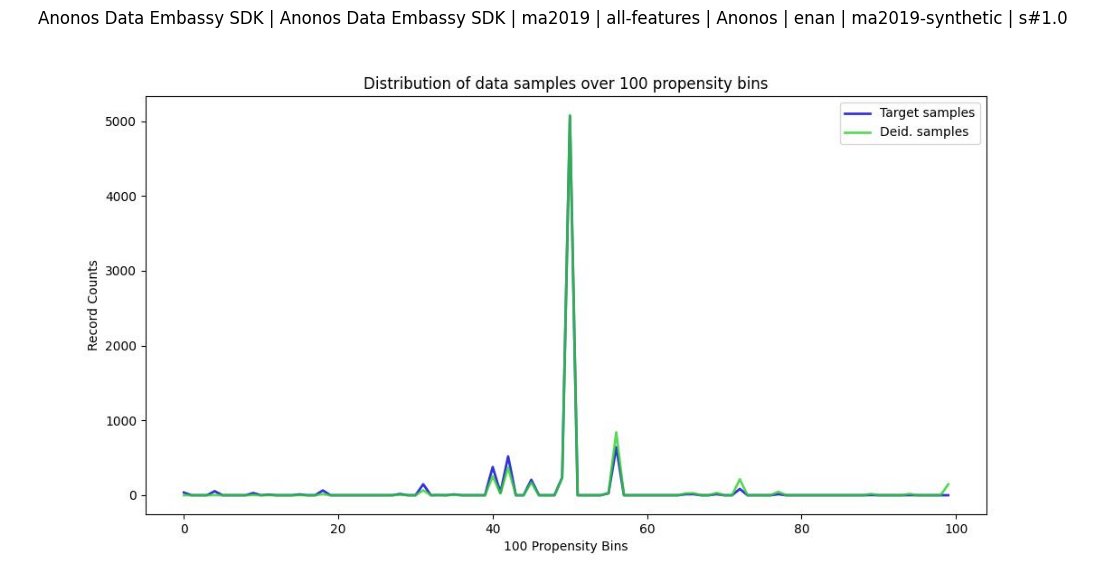

In [12]:
# get propensity plot path from 
# the deid dataset in the first 
# row of index dataframe
selected_df = idx_df.head(1)
propensity_plot_path = selected_df[PROPENSITY_PLOT_PATH].values[0]

# Create label for the selected deid data sample
deid_data_label = u.create_label(selected_df)[0]

# Show propensity mean square error plot of 
# the selected deid data sample
plot.draw_single_image(propensity_plot_path, deid_data_label)

<a id="nb2-section-3"></a>
## 3. Get percentage of deid samples in the 100th propensity bin.
We get the count of deid data samples in the 100th bin of propensity mean square error, and then calculate the percentage of these deid samples in 100th bin.

In [13]:
# Show available evaluations for propensity metric
# in a report.json file
# Relative path to propensity count is under
# propensity_distribution key
u.list_report(idx_df, PROPENSITY_MEAN_SQUARE_ERROR)

 propensity mean square error
--- pmse_score
--- propensity_distribution
--- plot


In [14]:
PROPENSITY_DIST_100th_BIN = 'propensity_dist_100th_bin'

# Create a new zero filled column
idx_df[PROPENSITY_DIST_100th_BIN] = np.zeros(idx_df.shape[0]).astype(int)

# Iterate over each row (deid dataset) in index dataframe.
for i, row in idx_df.iterrows():
    # Get path of the SDNIST evaluation report directory
    # for the deid dataset in current row.
    report_dir_path = row[REPORT_PATH]  # report directory path
    # Create path to the report.json file in the report directory.
    report_json_path = Path(report_dir_path, 'report.json')
    # Read the json file at report_json_path into a 
    # python dictionary variable report_dict.
    with open(report_json_path) as f:
        report_dict = json.load(f)
    # Get relative path to propensity metric distribution csv
    propensity_dist_path = report_dict[PROPENSITY_MEAN_SQUARE_ERROR][PROPENSITY_DISTRIBUTION]
    
    # Update path to be relative to crc_data_and_metric_bundle directory
    propensity_dist_path = Path(report_dir_path, propensity_dist_path)
    
    # Read propensity distribution csv into pandas dataframe
    propensity_dist_df = pd.read_csv(propensity_dist_path)

    # get total count of all bins in Deid samples of propensity metric
    total_count = propensity_dist_df[DEID_SAMPLES].sum()
    
    # Save count of Deid data samples in the 100th bin (we use 99 here since index is 0 based)
    # of propensity distribution
    bin_100th_count = propensity_dist_df.loc[99, DEID_SAMPLES]
    
    # calculate percentage of deid samples in the 100th bin
    percent_count = (bin_100th_count / total_count) * 100
    
    # Save percentage of Deid data samples in the 100th bin (we use 99 here since index is 0 based)
    # of propensity distribution
    idx_df.loc[i, PROPENSITY_DIST_100th_BIN] = percent_count
    

# See random five records and 
# the new column propensity_dist_100th_bin which we added to 
# the index dataframe just now.
# Name of the columns to display in the selected data samples index
columns_to_show = [LIBRARY_NAME, ALGORITHM_NAME, ALGORITHM_TYPE, TARGET_DATASET,
                   PRIVACY_CATEGORY, EPSILON, FEATURE_SET_NAME, 
                   PROPENSITY_DIST_100th_BIN]
idx_df[columns_to_show].sample(5)

,library name,algorithm name,algorithm type,target dataset,privacy category,epsilon,feature set name,propensity_dist_100th_bin
276,smartnoise-synth,patectgan,neural net,ma2019,dp,5.0,demographic-focused,13.125491
343,synthcity,adsgan,neural net,national2019,non_dp,NaN,all-features,55.766338
29,Sarus SDG,Sarus SDG,neural net,national2019,dp,10.0,demographic-focused,1.521819
275,smartnoise-synth,patectgan,neural net,ma2019,dp,1.0,demographic-focused,89.900445
1,Anonos Data Embassy SDK,Anonos Data Embassy SDK,neural net,national2019,non_dp,NaN,all-features,0.209151


<a id="nb2-section-4"></a>
## 4. Get percentage of inconsistent records in each deid dataset.

Output of the following code cell shows the location of all the age based inconsistencies in a report.json file.

In [15]:
# Show available evaluations for 
# inconsistencies metric in a report.json file
u.list_report(idx_df, INCONSISTENCIES)

 inconsistencies
--- age
------ title
------ description
------ inconsistencies
--- work
------ title
------ description
------ inconsistencies
--- housing
------ title
------ description
------ inconsistencies
--- summary


In [16]:
PERCENT_INCONSISTENCIES = 'percent_inconsistencies'

# Create a zero filled column 'percent_inconsistencies' in the index dataframe 
idx_df[PERCENT_INCONSISTENCIES] = np.zeros(idx_df.shape[0]).astype(int)

# Iterate over each row (deid dataset) in index dataframe.
for i, row in idx_df.iterrows():
    # Get path of the SDNIST evaluation report directory
    # for the deid dataset in current row.
    report_dir_path = row[REPORT_PATH]  # report directory path
    # Create path to the report.json file in the report directory.
    report_json_path = Path(report_dir_path, 'report.json')
    # Read the json file at report_json_path into a 
    # python dictionary variable report_dict.
    with open(report_json_path) as f:
        report_dict = json.load(f)
        
    # Get the summary of inconsistencies metric. summary is a list
    # of summary in each inconsistency type.
    inconsistency_summaries = report_dict[INCONSISTENCIES][SUMMARY]
    
    # Get percentage of inconsistent record in each inconsistency type
    # and sum the list to get final percentage of inconsistencies in the
    # current deid dataset
    percent_inconsistencies = sum([summary[PERCENT_RECORDS_INCONSISTENT] 
                               for summary in inconsistency_summaries])
    
    # Save the percentage of inconsistent records in the 
    # 'percent_inconsistencies' column of the 
    # index dataframe.
    idx_df.loc[i, PERCENT_INCONSISTENCIES] = percent_inconsistencies

# Show random five records and the new column 
# 'total_inconsistencies' which we added to 
# the filtered index dataframe just now.
columns_to_show = [LIBRARY_NAME, ALGORITHM_NAME, ALGORITHM_TYPE, TARGET_DATASET,
                   PRIVACY_CATEGORY, EPSILON, FEATURE_SET_NAME, 
                   PROPENSITY_DIST_100th_BIN, PERCENT_INCONSISTENCIES]
idx_df[columns_to_show].sample(5)

,library name,algorithm name,algorithm type,target dataset,privacy category,epsilon,feature set name,propensity_dist_100th_bin,percent_inconsistencies
196,smartnoise-synth,mst,stat model,ma2019,dp,1.0,demographic-focused-except-DEYE,16.321719,29.2
297,smartnoise-synth,patectgan,neural net,national2019,dp,5.0,industry-focused,6.028694,4.6
51,rsynthpop,cart,stat model,national2019,non_dp,NaN,industry-focused,0.113749,0.0
247,smartnoise-synth,pacsynth,query matching,ma2019,dp,5.0,demographic-focused,1.761066,0.0
156,smartnoise-synth,aim,stat model,ma2019,dp,1.0,simple-features,66.623002,41.3


<a id="nb2-section-5"></a>
## 5. Plot relationship between percent deid samples in 100th propensity bin and percent inconsistencies.

<a id="nb2-section-5.1"></a>
### 5.1 Show relationship for different algorithm types.

In [17]:
u.index_feature_description(ALGORITHM_TYPE)


Index Column: 
-------------
algorithm type


Description:
-----------
A label indicating the general category of approach as specified below

sdc = 'Statistical Disclosure Control anonymization techniques-- Does direct perturbation, anonymization, redaction or generalization on individual records of target data'

query matching = 'Query Matching based synthetic data techniques-- Initializes a default synthetic data distribution and iteratively updates it to mimic query results on target data, using optimization or constraint satisfaction approaches'

neural net = 'Neural Network based synthetic data techniques-- Includes both GAN and Transformer Networks / Autoencoders'

stat model = 'Statistical Model based synthetic data techniques-- Uses some approach, other than a neural network, to construct a model of the feature relationships in the target data and uses this model to generate new records.'

histogram = 'Histogram based generation techniques-- Transforms the target data into a 

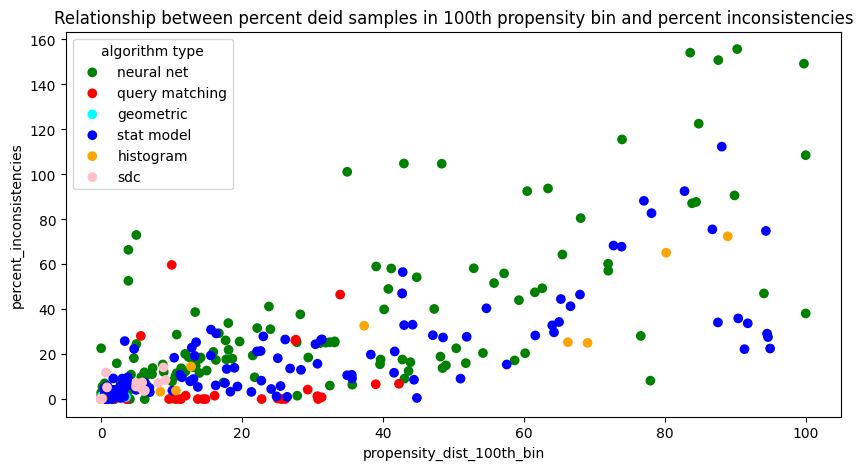

In [18]:
color_map = {
    'query matching': 'red',
    'neural net': 'green',
    'stat model': 'blue',
    'histogram': 'orange',
    'sdc': 'pink',
    'geometric': 'cyan'
}
plot.scatter(data=idx_df,
             x=PROPENSITY_DIST_100th_BIN,
             y=PERCENT_INCONSISTENCIES,
             color_by=ALGORITHM_TYPE,
             color_map=color_map,
             title='Relationship between percent deid samples in 100th propensity bin and percent inconsistencies')

<a id="nb2-section-5.1.1"></a>
#### 5.1.1 Show relationship for different algorithm types in only national2019 datasets.

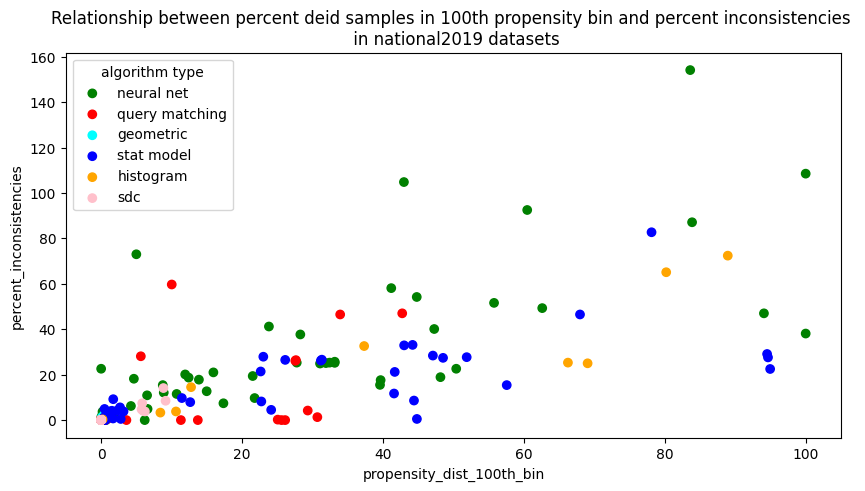

In [19]:
# Create mask to select deid datasets created from national2019 target dataset
mask = idx_df[TARGET_DATASET] == NATIONAL2019
na_idx_df = idx_df[mask]

# Plot relationship
plot.scatter(data=na_idx_df,
             x=PROPENSITY_DIST_100th_BIN,
             y=PERCENT_INCONSISTENCIES,
             color_by=ALGORITHM_TYPE,
             color_map=color_map,
             title='Relationship between percent deid samples in 100th propensity bin and percent inconsistencies \n in national2019 datasets')

<a id="nb2-section-5.1.2"></a>
#### 5.1.2 Show relationship for different algorithm types in only ma2019 datasets.

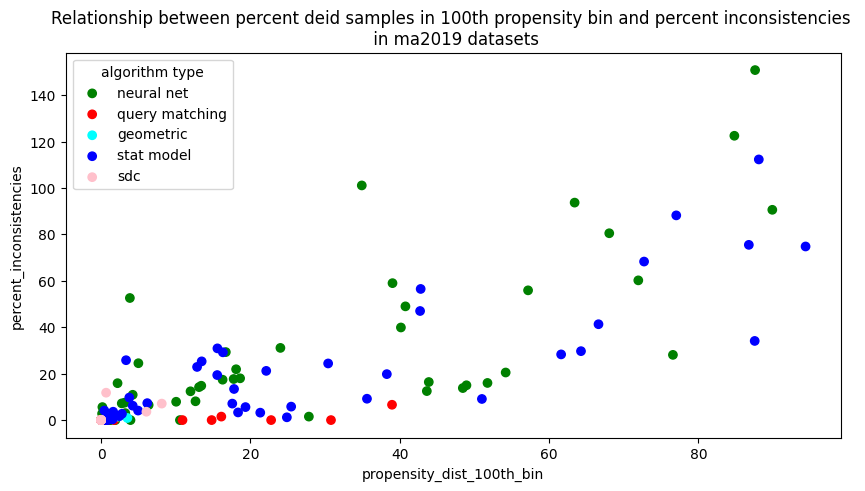

In [20]:
# Create mask to select deid datasets created from ma2019 target dataset
mask = idx_df[TARGET_DATASET] == MA2019
ma_idx_df = idx_df[mask]

# Plot relationship
plot.scatter(data=ma_idx_df,
             x=PROPENSITY_DIST_100th_BIN,
             y=PERCENT_INCONSISTENCIES,
             color_by=ALGORITHM_TYPE,
             color_map=color_map,
             title='Relationship between percent deid samples in 100th propensity bin and percent inconsistencies \n in ma2019 datasets')

<a id="nb2-section-5.1.3"></a>
#### 5.1.3 Show relationship for different algorithm types in only tx2019 datasets.

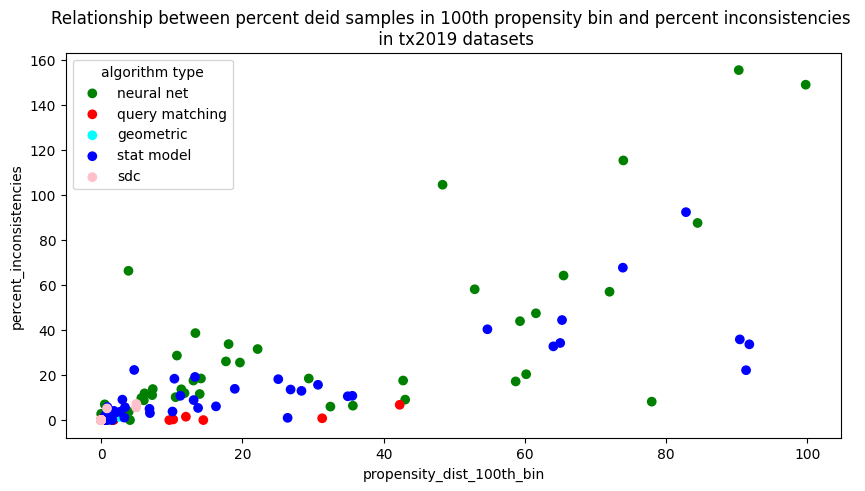

In [21]:
# Create mask to select deid datasets created from tx2019 target dataset
mask = idx_df[TARGET_DATASET] == TX2019
tx_idx_df = idx_df[mask]

# Plot relationship
plot.scatter(data=tx_idx_df,
             x=PROPENSITY_DIST_100th_BIN,
             y=PERCENT_INCONSISTENCIES,
             color_by=ALGORITHM_TYPE,
             color_map=color_map,
             title='Relationship between percent deid samples in 100th propensity bin and percent inconsistencies \n in tx2019 datasets')

<a id="nb2-section-5.2"></a>
### 5.2 Show relationship for different privacy categories.

In [22]:
u.index_feature_description(PRIVACY_CATEGORY)


Index Column: 
-------------
privacy category


Description:
-----------
A code indicating the general category of privacy protection as specified below

sdc = 'Statistical Disclosure Control'

dp = 'Differential Privacy'

non_dp = 'Synthetic Data (Non-differentially Private)'


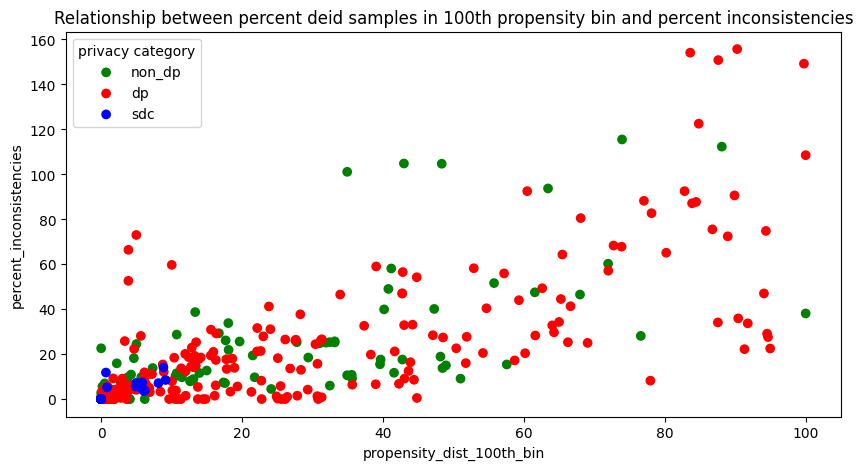

In [23]:
color_map = {
    'dp': 'red',
    'non_dp': 'green',
    'sdc': 'blue'
}
plot.scatter(data=idx_df,
             x=PROPENSITY_DIST_100th_BIN,
             y=PERCENT_INCONSISTENCIES,
             color_by=PRIVACY_CATEGORY,
             color_map=color_map,
             title='Relationship between percent deid samples in 100th propensity bin and percent inconsistencies')

<a id="nb2-section-5.2.1"></a>
#### 5.2.1 Show relationship for different privacy categories in only national2019 datasets.

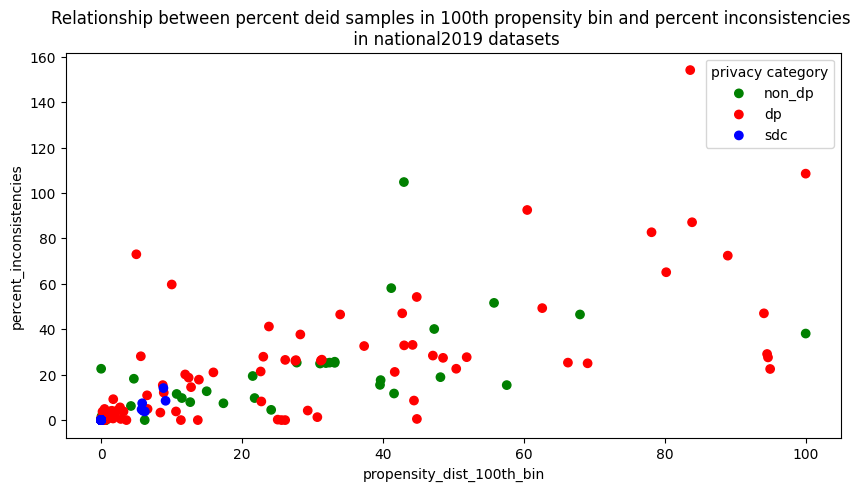

In [24]:
# Create mask to select deid datasets created from national2019 target dataset
mask = idx_df[TARGET_DATASET] == NATIONAL2019
na_idx_df = idx_df[mask]

# Plot relationship
plot.scatter(data=na_idx_df,
             x=PROPENSITY_DIST_100th_BIN,
             y=PERCENT_INCONSISTENCIES,
             color_by=PRIVACY_CATEGORY,
             color_map=color_map,
             title='Relationship between percent deid samples in 100th propensity bin and percent inconsistencies \n in national2019 datasets')

<a id="nb2-section-5.2.2"></a>
#### 5.2.2 Show relationship for different privacy categories in only ma2019 datasets.

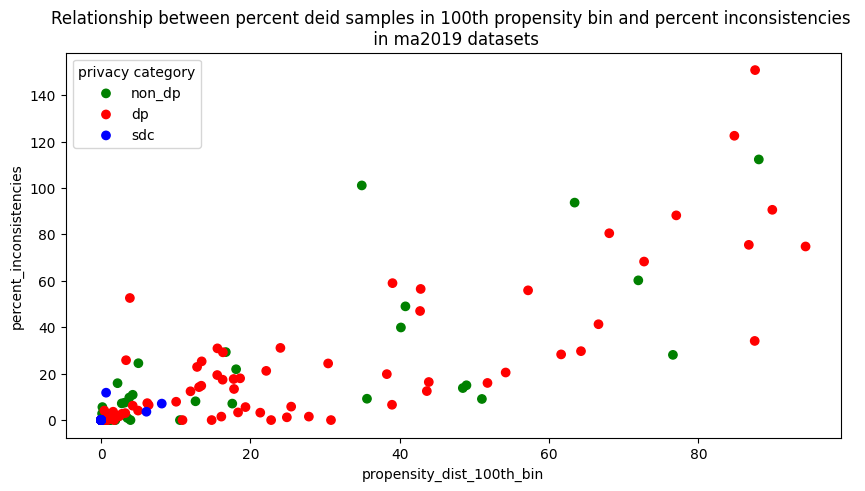

In [25]:
# Create mask to select deid datasets created from ma2019 target dataset
mask = idx_df[TARGET_DATASET] == MA2019
ma_idx_df = idx_df[mask]

# Plot relationship
plot.scatter(data=ma_idx_df,
             x=PROPENSITY_DIST_100th_BIN,
             y=PERCENT_INCONSISTENCIES,
             color_by=PRIVACY_CATEGORY,
             color_map=color_map,
             title='Relationship between percent deid samples in 100th propensity bin and percent inconsistencies \n in ma2019 datasets')

<a id="nb2-section-5.2.3"></a>
#### 5.2.3 Show relationship for different privacy categories in only tx2019 datasets.

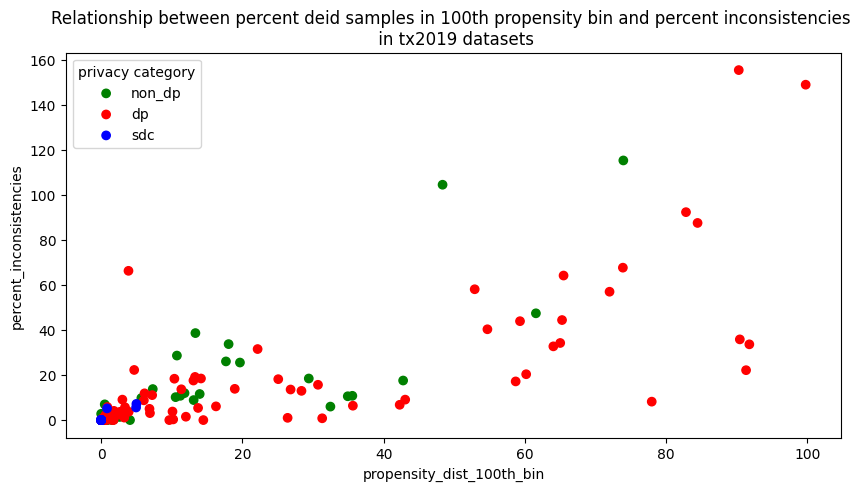

In [26]:
# Create mask to select deid datasets created from tx2019 target dataset
mask = idx_df[TARGET_DATASET] == TX2019
tx_idx_df = idx_df[mask]

# Plot relationship
plot.scatter(data=tx_idx_df,
             x=PROPENSITY_DIST_100th_BIN,
             y=PERCENT_INCONSISTENCIES,
             color_by=PRIVACY_CATEGORY,
             color_map=color_map,
             title='Relationship between percent deid samples in 100th propensity bin and percent inconsistencies \n in tx2019 datasets')